# Flower Classification

In [ ]:
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [ ]:
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [ ]:
#!tar -xf 102flowers.tgz

In [18]:
from scipy import io
import tensorflow as tf
import keras
#from keras.applications import MobileNet
from keras.applications import EfficientNetV2B0
from keras.applications.efficientnet_v2 import preprocess_input
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil

## Loading Image's Label

In [19]:
mat_data = io.loadmat('imagelabels.mat')
labels = mat_data['labels'].flatten()
np.random.seed(42)

## Data Visualization

C:\Users\negar\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\negar\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


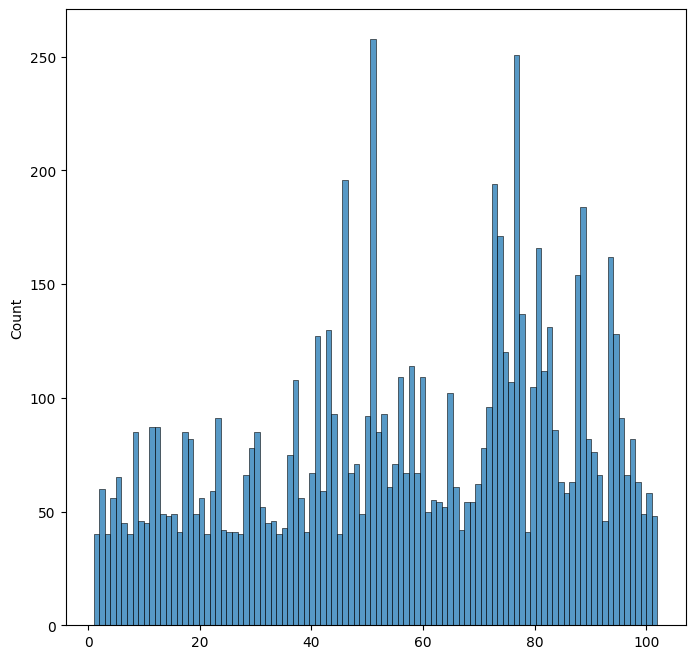

In [25]:
fig = plt.figure(figsize=(8, 8))
sns.histplot(labels, bins=102);

Looking at the distribution of the classes, it's evident that our dataset suffers from significant **imbalance**.



## Loading Dataset

Images are labeled in the format image_0****.jpg, with corresponding labels indexed according to the image number. It's important to note that the image numbering starts from 1, mirroring the labeling scheme.

In [21]:
image_folder = "./102flowers"

image_files = os.listdir(image_folder)
image_files = sorted(image_files)
image_files = np.asarray(image_files)

## Train/Validation Split

Rather than randomly selecting 20% of the data for validation, which could favor some classes over others, a fairer method involves taking 20% from each class. This way, we maintain balance across all classes in our validation set.

In [3]:
VALIDATION_SPLIT = 0.2
counts = {}
for lbl in labels:
    counts[lbl] = counts.get(lbl, 0) + 1

def get_train_validation_split(img_dirs, labels, counts):
    validation_split = {}
    for k, v in counts.items():
        validation_split[k] = int(v * VALIDATION_SPLIT)

    img_lbl = list(zip(img_dirs, labels))
    random.shuffle(img_lbl)
    training = []
    validation = []
    for img, lbl in img_lbl:
        if validation_split[lbl] == 0: 
            training.append([img, lbl-1])
            continue
        validation.append([img, lbl-1])
        validation_split[lbl] -= 1

    return training, validation

In [22]:
training_lbl, validation_lbl = get_train_validation_split(image_files, labels, counts)

training_files = [x for x, y in training_lbl]
training_labels = [y for x, y in training_lbl]

validation_files = [x for x, y in validation_lbl]
validation_labels = [y for x, y in validation_lbl]

## Creating Pipline

In [26]:
tf.config.optimizer.set_jit(True)

augment_layer = keras.Sequential([
    keras.layers.RandomTranslation(0.12, 0.12),
    keras.layers.RandomRotation(0.1),
])

def normalize(img):
    return preprocess_input(img)

def read_image_label(image_path, label):
    path = tf.strings.join([image_folder, image_path], separator='/')
    imagesFile = tf.io.read_file(path)
    img = tf.image.decode_jpeg(imagesFile)
    return img, label

def augmentation(img):
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_contrast(img, 0.5, 1.2)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.6, 1.2)
    img = tf.clip_by_value(img, 0, 255)
    return img

def training_set(img, label):
    img = tf.image.resize(img, size=[224, 224])
    img = augmentation(img)
    img = augment_layer(img)
    img = normalize(img)
    label = tf.one_hot(label, 102)
    return img, label

def validation_set(img, label):
    img = tf.image.resize(img, (224,224))
    img = normalize(img)
    label = tf.one_hot(label, 102)
    return img, label

In [ ]:
training = tf.data.Dataset.from_tensor_slices((training_files, training_labels))
validation = tf.data.Dataset.from_tensor_slices((validation_files, validation_labels))

BUFFER_SIZE = 1000
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

training = training.map(read_image_label, num_parallel_calls=AUTOTUNE)
training = training.cache().map(training_set, num_parallel_calls=AUTOTUNE)
training = training.shuffle(BUFFER_SIZE)
training = training.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
training = training.prefetch(AUTOTUNE)

validation = validation.map(read_image_label, num_parallel_calls=AUTOTUNE)
validation = validation.map(validation_set, num_parallel_calls=AUTOTUNE)
validation = validation.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
validation = validation.prefetch(AUTOTUNE)

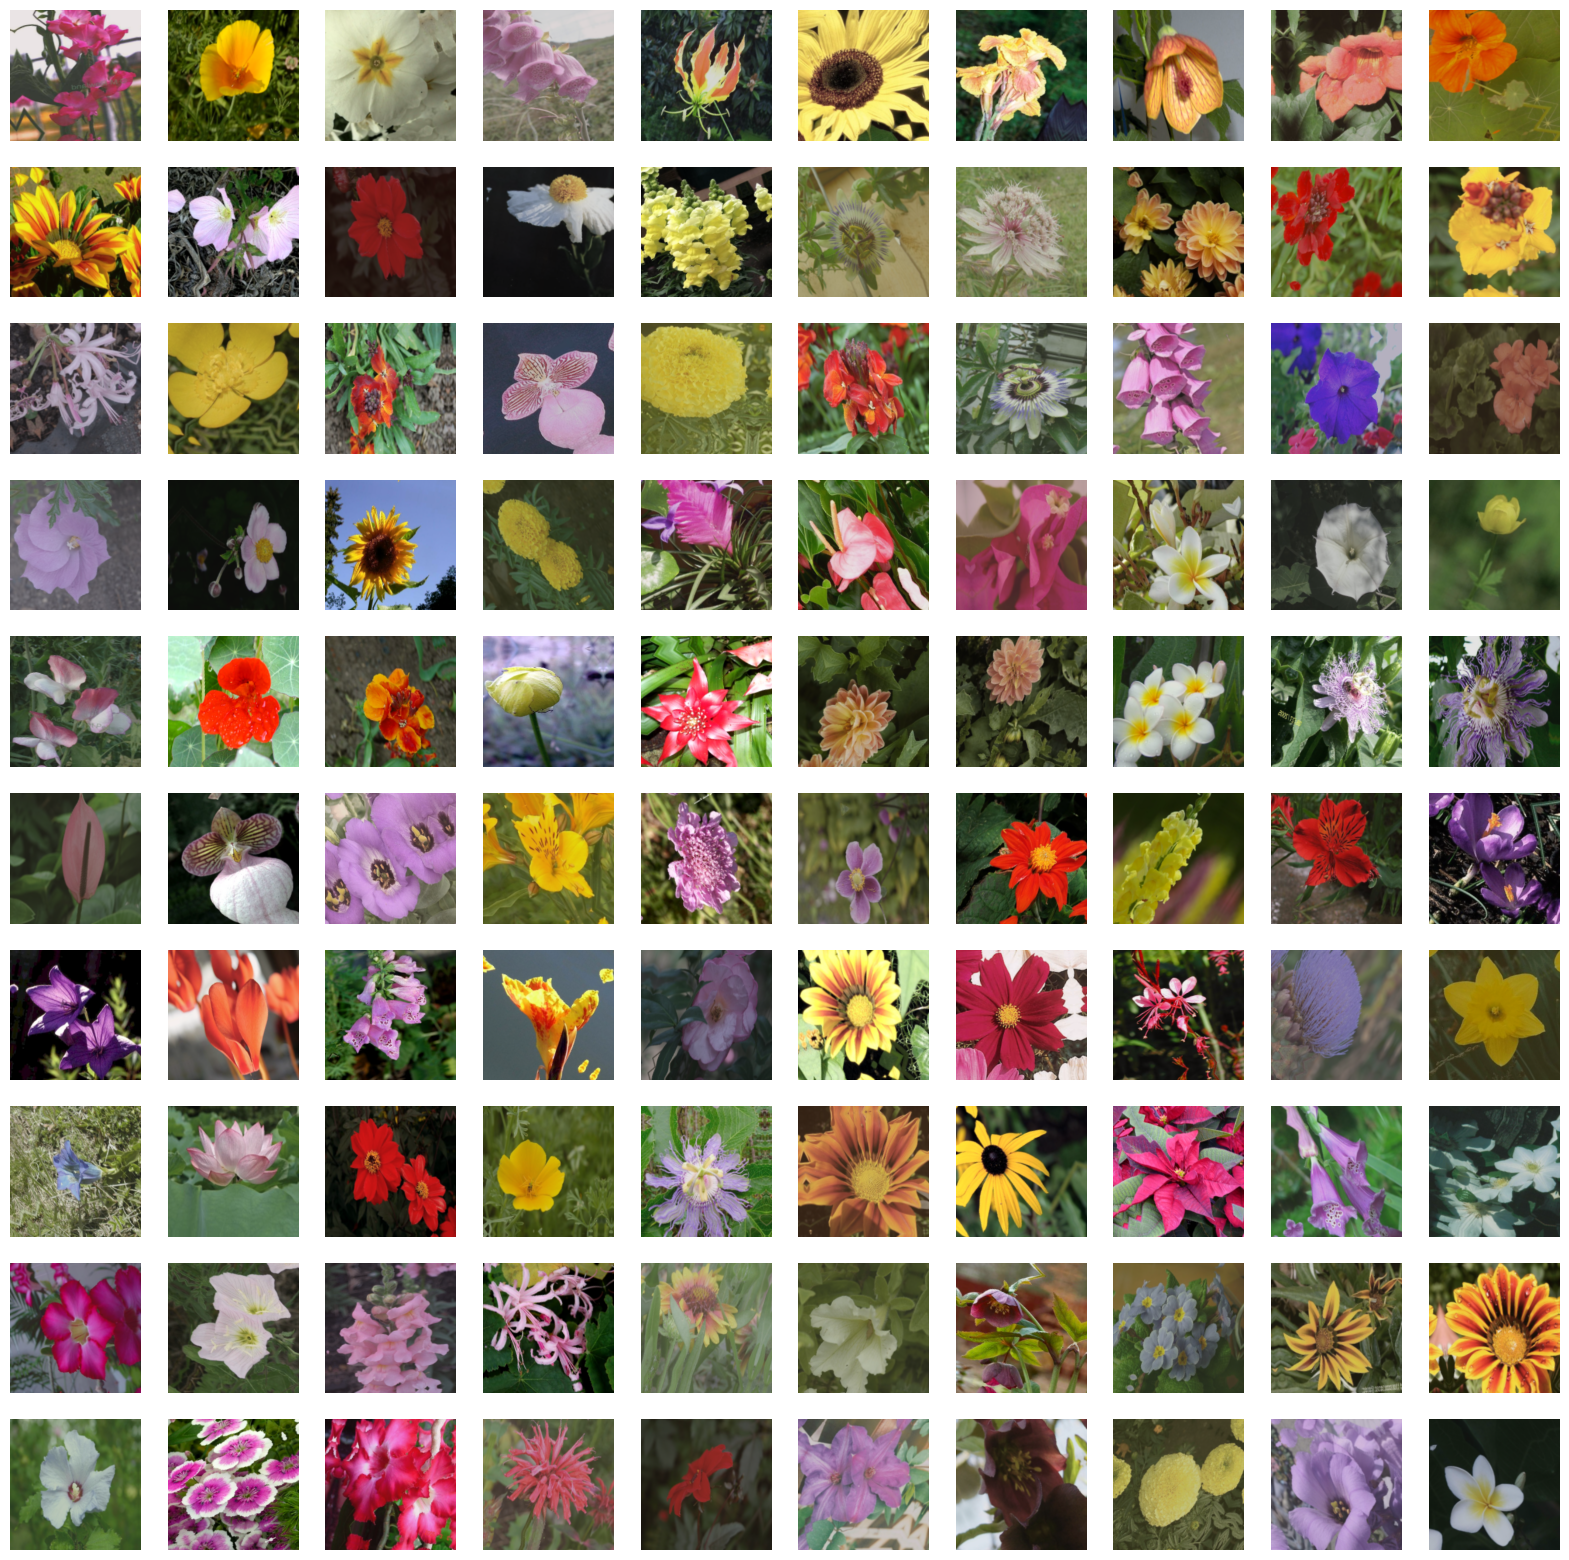

In [ ]:
fig = plt.figure(figsize=(20, 20))
cnt = 0
for imgs, lbls in training.take(2):
    for img in imgs:
        if cnt == 100: break
        ax = plt.subplot(10, 10, cnt + 1)
        ax.imshow(img/255)
        ax.axis('off')
        cnt += 1
    if cnt == 100: break

In [ ]:
img = next(iter(training.take(10)))[0]
print('Training')
print(f'\nMAX: {np.max(img)} \nMIN: {np.min(img)} \nMEAN: {np.mean(img)} \nSTD: {np.std(img)}')

img = next(iter(training.take(10)))[0]
print('\nValidation')
print(f'\nMAX: {np.max(img)} \nMIN: {np.min(img)} \nMEAN: {np.mean(img)} \nSTD: {np.std(img)}')

Training

MAX: 255.0 
MIN: 0.0 
MEAN: 90.9694595336914 
STD: 62.052452087402344

Validation

MAX: 255.0 
MIN: 0.0 
MEAN: 100.64656829833984 
STD: 62.33140182495117


## Creating a model

In [ ]:
conv_base = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras.regularizers import l2

model = models.Sequential()

# Add the convolutional base
model.add(conv_base)

# Global average pooling layer
model.add(layers.GlobalAveragePooling2D())

# Dropout layer for regularization
model.add(layers.Dropout(0.7))

# Dense output layer with softmax activation for classification
model.add(layers.Dense(102, activation='softmax'))


In [ ]:
conv_base.trainable = True
for l in conv_base.layers[:149]:
    l.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 6049974 (23.08 MB)
Trainable params: 4617362 (17.61 MB)
Non-trainable params: 1432612 (5.46 MB)
_________________________________________________________________


In [ ]:
initial_learning_rate = 1e-3

# Define the learning rate schedule
def lr_schedule(epoch):
    return max(1e-4, initial_learning_rate * 0.95 ** (epoch))

# Create a learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile the model with the specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
counts = {}
for l in labels:
    counts[l] = counts.get(l, 0) + 1

total_samples = sum(counts.values())
class_weights = {
    label: total_samples / (count * 102)
    for label, count in counts.items()
}
# Shift the keys of the class_weights dictionary
class_weights_shifted = {key - 1: value for key, value in class_weights.items()}

# Print the class counts
for label, count in sorted(counts.items()):
    print(f"Class {label:<3}: {count:>4} samples, weight is {class_weights[label]:<2.2f}")

Class 1  :   40 samples, weight is 2.01
Class 2  :   60 samples, weight is 1.34
Class 3  :   40 samples, weight is 2.01
Class 4  :   56 samples, weight is 1.43
Class 5  :   65 samples, weight is 1.24
Class 6  :   45 samples, weight is 1.78
Class 7  :   40 samples, weight is 2.01
Class 8  :   85 samples, weight is 0.94
Class 9  :   46 samples, weight is 1.75
Class 10 :   45 samples, weight is 1.78
Class 11 :   87 samples, weight is 0.92
Class 12 :   87 samples, weight is 0.92
Class 13 :   49 samples, weight is 1.64
Class 14 :   48 samples, weight is 1.67
Class 15 :   49 samples, weight is 1.64
Class 16 :   41 samples, weight is 1.96
Class 17 :   85 samples, weight is 0.94
Class 18 :   82 samples, weight is 0.98
Class 19 :   49 samples, weight is 1.64
Class 20 :   56 samples, weight is 1.43
Class 21 :   40 samples, weight is 2.01
Class 22 :   59 samples, weight is 1.36
Class 23 :   91 samples, weight is 0.88
Class 24 :   42 samples, weight is 1.91
Class 25 :   41 samples, weight is 1.96


In [ ]:
epochs = 5
history = model.fit(
    training,
    validation_data=validation,
    epochs=epochs, 
    class_weight=class_weights_shifted,
    callbacks=[lr_callback]
)

Epoch 1/5


2024-03-28 00:18:45.516616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711572531.502486   44718 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711572546.640746   44714 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - ETA: 0s - loss: 2.2854 - acc: 0.5268 - precision: 0.9306 - recall: 0.2994

W0000 00:00:1711572572.704769   44708 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - 59s 222ms/step - loss: 2.2854 - acc: 0.5268 - precision: 0.9306 - recall: 0.2994 - val_loss: 0.3928 - val_acc: 0.9139 - val_precision: 0.9598 - val_recall: 0.8340 - lr: 0.0010
Epoch 2/5
103/103 [==============================] - ETA: 0s - loss: 0.4184 - acc: 0.8928 - precision: 0.9458 - recall: 0.8245

W0000 00:00:1711572605.700935   44718 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - 37s 349ms/step - loss: 0.4184 - acc: 0.8928 - precision: 0.9458 - recall: 0.8245 - val_loss: 0.1595 - val_acc: 0.9544 - val_precision: 0.9702 - val_recall: 0.9363 - lr: 9.5000e-04
Epoch 3/5


W0000 00:00:1711572612.021588   44708 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - 14s 127ms/step - loss: 0.2304 - acc: 0.9403 - precision: 0.9629 - recall: 0.9065 - val_loss: 0.1421 - val_acc: 0.9632 - val_precision: 0.9659 - val_recall: 0.9544 - lr: 9.0250e-04
Epoch 4/5
103/103 [==============================] - 14s 130ms/step - loss: 0.1501 - acc: 0.9554 - precision: 0.9735 - recall: 0.9376 - val_loss: 0.1049 - val_acc: 0.9719 - val_precision: 0.9773 - val_recall: 0.9657 - lr: 8.5737e-04
Epoch 5/5
103/103 [==============================] - 14s 131ms/step - loss: 0.1057 - acc: 0.9699 - precision: 0.9791 - recall: 0.9590 - val_loss: 0.1220 - val_acc: 0.9613 - val_precision: 0.9660 - val_recall: 0.9563 - lr: 8.1451e-04


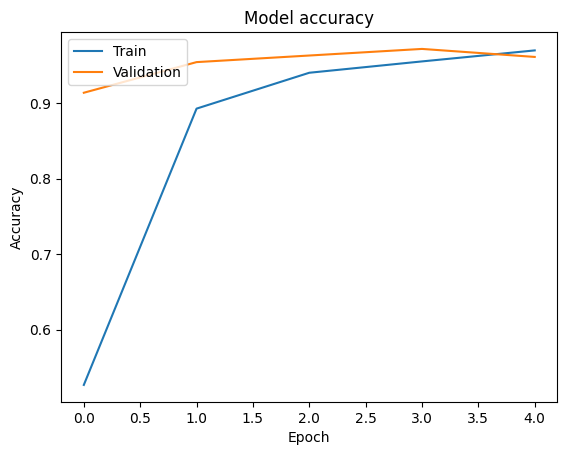

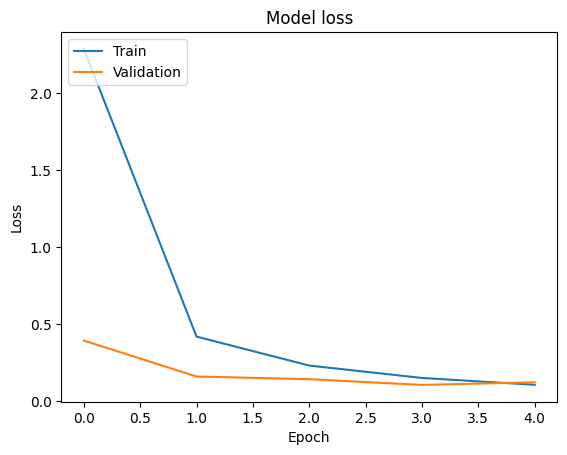

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the object returned by model.fit()
# It typically contains loss and metrics values for each epoch
# You can access them as `history.history['loss']` and `history.history['val_loss']`
# if you're interested in the loss values.

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
base = model.layers[0]
for i, l in enumerate(base.layers):
    print(f'{i:>3}', f'{l.name:>20}')

  0              input_1
  1            rescaling
  2        normalization
  3            stem_conv
  4              stem_bn
  5      stem_activation
  6 block1a_project_conv
  7   block1a_project_bn
  8 block1a_project_activation
  9  block2a_expand_conv
 10    block2a_expand_bn
 11 block2a_expand_activation
 12 block2a_project_conv
 13   block2a_project_bn
 14  block2b_expand_conv
 15    block2b_expand_bn
 16 block2b_expand_activation
 17 block2b_project_conv
 18   block2b_project_bn
 19         block2b_drop
 20          block2b_add
 21  block3a_expand_conv
 22    block3a_expand_bn
 23 block3a_expand_activation
 24 block3a_project_conv
 25   block3a_project_bn
 26  block3b_expand_conv
 27    block3b_expand_bn
 28 block3b_expand_activation
 29 block3b_project_conv
 30   block3b_project_bn
 31         block3b_drop
 32          block3b_add
 33  block4a_expand_conv
 34    block4a_expand_bn
 35 block4a_expand_activation
 36      block4a_dwconv2
 37           block4a_bn
 38   block4a_activ

In [ ]:
model.trainable = True
for i in range(76):
    base.layers[i].trainable = False


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 6049974 (23.08 MB)
Trainable params: 5564410 (21.23 MB)
Non-trainable params: 485564 (1.85 MB)
_________________________________________________________________


## Fine Tuning

In [ ]:
initial_learning_rate = 1e-4

# Define the learning rate schedule
def lr_schedule(epoch):
    return max(1e-6, initial_learning_rate * 0.99 ** (epoch))

# Create a learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
epochs = 30
history = model.fit(
    training,
    validation_data=validation,
    epochs=epochs, 
    class_weight=class_weights_shifted,
    callbacks=[lr_callback])

Epoch 1/30
103/103 [==============================] - 14s 129ms/step - loss: 0.0805 - acc: 0.9754 - precision: 0.9836 - recall: 0.9677 - val_loss: 0.0607 - val_acc: 0.9825 - val_precision: 0.9874 - val_recall: 0.9782 - lr: 1.0000e-04
Epoch 2/30
103/103 [==============================] - 14s 131ms/step - loss: 0.0538 - acc: 0.9876 - precision: 0.9913 - recall: 0.9813 - val_loss: 0.0566 - val_acc: 0.9819 - val_precision: 0.9862 - val_recall: 0.9806 - lr: 9.9000e-05
Epoch 3/30
103/103 [==============================] - 14s 131ms/step - loss: 0.0466 - acc: 0.9882 - precision: 0.9919 - recall: 0.9803 - val_loss: 0.0538 - val_acc: 0.9838 - val_precision: 0.9875 - val_recall: 0.9831 - lr: 9.8010e-05
Epoch 4/30
103/103 [==============================] - 14s 130ms/step - loss: 0.0371 - acc: 0.9892 - precision: 0.9930 - recall: 0.9863 - val_loss: 0.0527 - val_acc: 0.9850 - val_precision: 0.9887 - val_recall: 0.9838 - lr: 9.7030e-05
Epoch 5/30
103/103 [==============================] - 14s 131ms/

## Classification Report


In [ ]:
from sklearn.metrics import classification_report

prediction = model.predict(validation)
predicted_labels = np.argmax(prediction, axis=1)
print(classification_report(validation_labels, predicted_labels))

 3/26 [==>...........................] - ETA: 1s

W0000 00:00:1711573093.102293   44705 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 [==============================] - 6s 66ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         8
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00        13
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        17
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00        17
          11       1.00      0.94      0.97        17
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8
          16       1.00    

In [ ]:
model.save('model.keras')